Link to paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7948653/
Link to GitHub: https://github.com/NourozR/Stock-Price-Prediction-LSTM/blob/master/StockPricePrediction.py

**LOAD IN preprocessing.py and INDEX.csv INTO RUNTIME FOR CODE TO RUN**

In [110]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import preprocessing 
import yahoodata as yd # File added as a function to parse our index data

In [138]:
# IMPORTING DATASET
# This whole cell is brand new, utilizing pullStockData function from yahoodata
# XLV: Health Care Select Sector SPDR Fund

dataset = yd.pullStockData("XLV", 2016, 3, 31, 2021, 11, 17)

dataset


,High,Low,Open,Close
Date,,,,
2016-03-31,68.290001,67.750000,67.889999,67.779999
2016-04-01,68.800003,67.370003,67.500000,68.550003
2016-04-04,69.620003,68.699997,68.709999,69.370003
2016-04-05,68.879997,68.309998,68.559998,68.470001
2016-04-06,70.339996,68.489998,68.489998,70.309998
...,...,...,...,...
2021-11-11,133.610001,132.830002,133.520004,133.149994
2021-11-12,134.119995,133.070007,134.000000,133.809998
2021-11-15,134.190002,132.850006,134.119995,132.979996


In [112]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [113]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

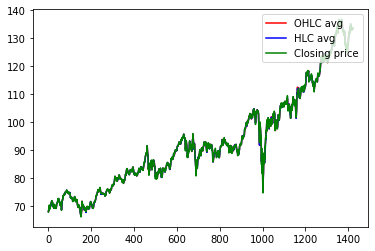

In [114]:
# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()


In [115]:
# PREPARATION OF TIME SERIES DATASET
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [116]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.7) # Changed to a 30/70 split from original dataset
train_OHLC_placeholder = train_OHLC
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [117]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = preprocessing.new_dataset(train_OHLC, 1)
testX, testY = preprocessing.new_dataset(test_OHLC, 1)

In [118]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [119]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [120]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse','mae']) # Switched from SGD to adam
history = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2) # Changed from 5 to 50 epochs

Epoch 1/50
992/992 - 6s - loss: 0.0065 - mse: 0.0065 - mae: 0.0471 - val_loss: 8.9970e-04 - val_mse: 8.9970e-04 - val_mae: 0.0265 - 6s/epoch - 6ms/step
Epoch 2/50
992/992 - 3s - loss: 1.6654e-04 - mse: 1.6654e-04 - mae: 0.0100 - val_loss: 4.1591e-04 - val_mse: 4.1591e-04 - val_mae: 0.0149 - 3s/epoch - 3ms/step
Epoch 3/50
992/992 - 2s - loss: 1.3664e-04 - mse: 1.3664e-04 - mae: 0.0088 - val_loss: 3.9250e-04 - val_mse: 3.9250e-04 - val_mae: 0.0146 - 2s/epoch - 2ms/step
Epoch 4/50
992/992 - 2s - loss: 1.1794e-04 - mse: 1.1794e-04 - mae: 0.0081 - val_loss: 4.1753e-04 - val_mse: 4.1753e-04 - val_mae: 0.0146 - 2s/epoch - 2ms/step
Epoch 5/50
992/992 - 2s - loss: 1.2756e-04 - mse: 1.2756e-04 - mae: 0.0085 - val_loss: 3.9155e-04 - val_mse: 3.9155e-04 - val_mae: 0.0147 - 2s/epoch - 2ms/step
Epoch 6/50
992/992 - 2s - loss: 1.1657e-04 - mse: 1.1657e-04 - mae: 0.0079 - val_loss: 4.2634e-04 - val_mse: 4.2634e-04 - val_mae: 0.0165 - 2s/epoch - 2ms/step
Epoch 7/50
992/992 - 2s - loss: 1.1978e-04 - mse

In [121]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [122]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [123]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 0.74


In [124]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))


Test RMSE: 4.19


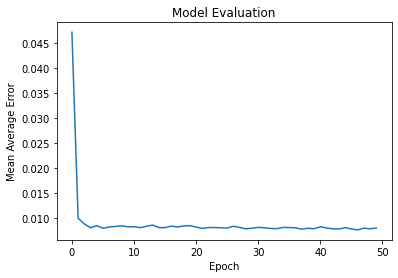

In [125]:
# GRAPHING EVALUATION METRICS

plt.plot(history.history['mae'])
plt.plot(history.history['mse'])

plt.title('Model Evaluation')
plt.ylabel("Mean Average Error")
plt.xlabel("Epoch")
plt.show()

In [126]:
# RESULTS FOR MAE AND MSE
results = model.evaluate(testPredict, np.concatenate(testY), batch_size = 1)


425/425 [==============================] - 2s 2ms/step - loss: 12804.9961 - mse: 12804.9961 - mae: 112.4178
test loss, test mae: [12804.99609375, 12804.99609375, 112.41778564453125]


In [127]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [128]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

In [129]:
# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

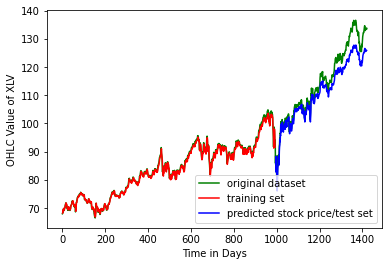

In [139]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'lower right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of XLV')
plt.savefig("images/XLV.png", dpi=1000)  #Added this line to save a picture of the plot itself
plt.show()


In [131]:
# PREDICT FUTURE VALUES (Valuation)
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))


In [132]:
# PRINT LAST VALUE

"Last Day Value:", last_val.item()

('Last Day Value:', 125.87567138671875)

In [133]:
# PRINT NEXT DAY PREDICTED VALUE

"Next Day Value:", (last_val*next_val).item()

('Next Day Value:', 110.09723663330078)